# Cough splitter using a KNN classifier

Let's implement a classifier that uses a moving window travelling the audio file.

In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import os

In [2]:
window_size = 1000

We will use data in this form : an instance is a window taken from a signal, each value in this window is a feature.

In [3]:
fs, data = wavfile.read('cough_test_1.wav')
cough = data[:,1] #There are two tracks (stereo), we arbitrarly take the second one 

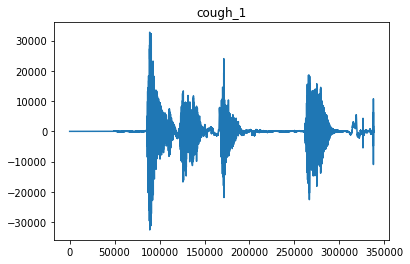

In [4]:
plt.figure()
plt.title('cough_1')
plt.plot(cough)
plt.show()

Let's label some of the windows to fit a model.

In [5]:
starting_cough_i = 261062
ending_cough_i = 295000
starting_nocough_i = 194000
ending_nocough_i = 258000

In [6]:
random_i_cough = np.random.choice(np.arange(starting_cough_i,ending_cough_i-window_size),10000,replace=False)
random_i_nocough = np.random.choice(np.arange(starting_nocough_i,ending_nocough_i-window_size),10000,replace=False)

In [7]:
data = np.zeros((20000,window_size+1))
sig = (cough/np.max(cough))**3
for i,i_choice in enumerate(random_i_cough):
    data[i,:window_size] = sig[i_choice:i_choice+window_size]
    data[i,window_size] = 1
for i,i_choice in enumerate(random_i_nocough):
    data[i+10000,:window_size] = sig[i_choice:i_choice+window_size]
    data[i+10000,window_size] = 0

In [8]:
np.random.shuffle(data)

In [9]:
data_train,data_test = train_test_split(data)

In [10]:
X_train,Y_train = data_train[:,:1000],data_train[:,1000]
X_test,Y_test = data_test[:,:1000],data_test[:,1000]

Let's train a model on this dataset

In [11]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=3)

In [12]:
clf.score(X_test,Y_test)

0.9988

By slicing an audio file into several windows of the right size we can make a prediction on every window.
Let's implement this.

In [13]:
def plot_clf_pred(clf,sig):
    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(111)
    max_cough = np.max(sig)
    signal = np.copy(sig)
    signal = signal/max_cough
    signal = signal**3
    for i in range(len(sig)//window_size):
        window = signal[i*window_size:(i+1)*window_size]
        label = clf.predict(window.reshape(1,-1))
        color = 'g'
        if label==1:
            color = 'r'
        rect = matplotlib.patches.Rectangle((i*window_size,-50000), window_size, 100000, color=color,alpha=0.1)
        ax.add_patch(rect)
    plt.plot(sig)
    plt.title('Classifier predictions',fontsize=18)
    plt.ylabel('Amplitude',fontsize=18)
    plt.xlabel('Time',fontsize=18)
    plt.ylim(np.min(sig)*1.2,np.max(sig)*1.2)
    plt.xlim(0,len(sig))
    plt.show()

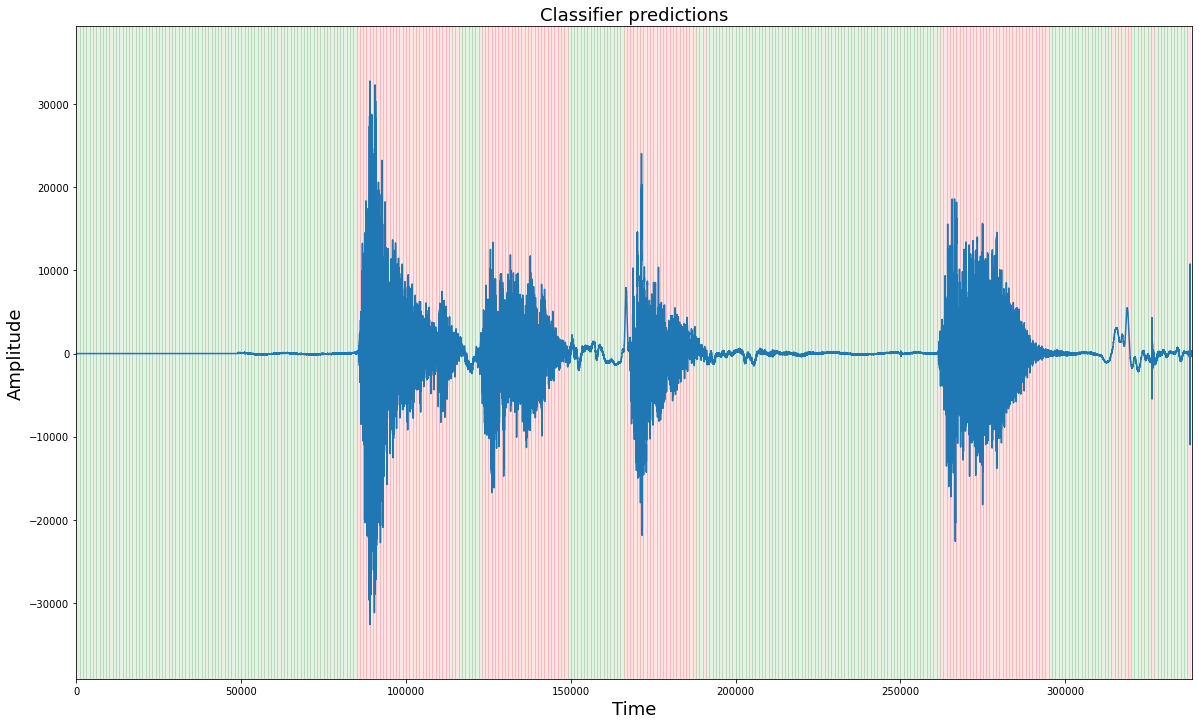

In [14]:
plot_clf_pred(clf,cough)

Let's test another cough, which has a different sampling rate.

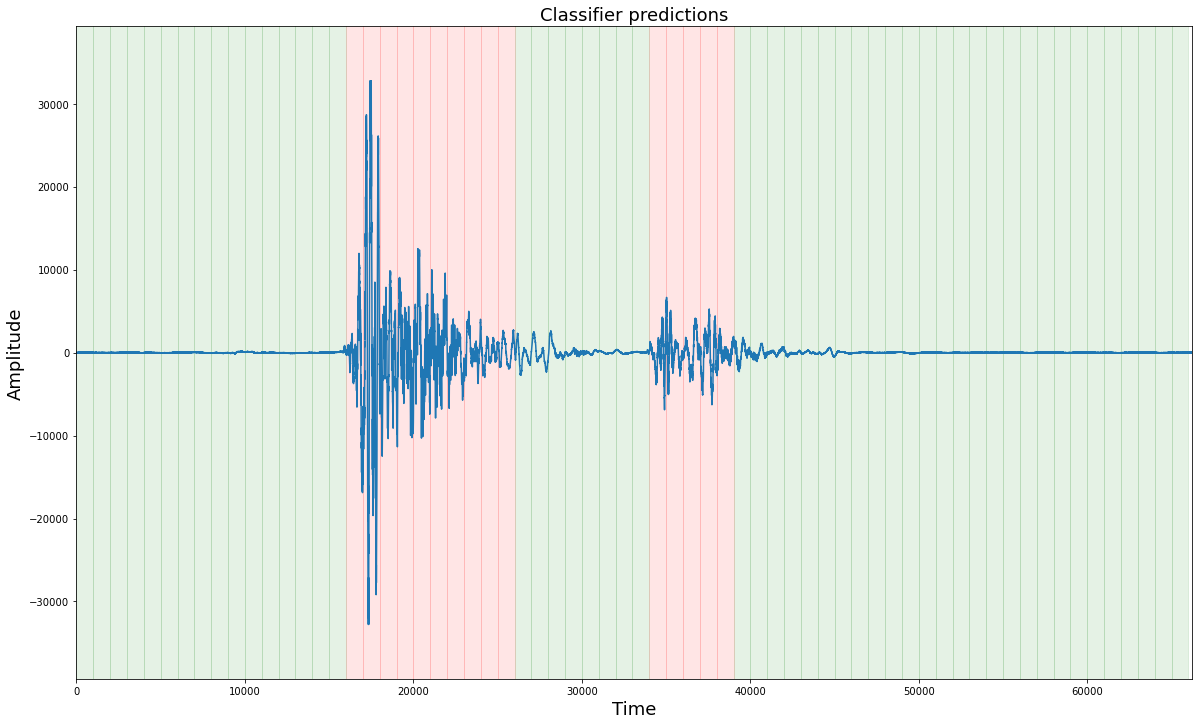

In [15]:
fs, cough2 = wavfile.read('Coughing/17167__lg__cough01.wav')
cough2 = cough2[:,1]
plot_clf_pred(clf,cough2)

## Get the cut from the classification of windows

Now that we know the prediction of the model for every window, we have to extract the indexes of the cut. We are making a decision which is : at the index i we look at the windows [ i, i+1, i+2, i+3], if there are 3 positive windows the cough starts at i, if there are 3 negative windows the cough is ended at i+2.

In [16]:
def get_cut(clf,sig):
    max_cough = np.max(sig)
    signal = np.copy(sig)
    signal = signal/max_cough
    signal = signal**3
    labels = []
    for i in range(len(sig)//window_size):
        window = signal[i*window_size:(i+1)*window_size]
        label = clf.predict(window.reshape(1,-1))
        labels.append(int(label))
    start_ind = []
    end_ind = []
    double_continue = 0
    for j in range(len(labels)-3):
        if double_continue>=1:
            double_continue-=1
            continue
        if len(start_ind)-len(end_ind) == 0 and np.sum(labels[j:j+4])>=3:
            start_ind.append(j*window_size)
        elif len(start_ind)-len(end_ind) == 1 and np.sum(labels[j:j+4])<=1:
            double_continue = 2
            end_ind.append((j+2)*window_size)
    return start_ind,end_ind

In [17]:
def plot_cut_sig(signal,extremities):
    plt.figure(figsize=(20,12))
    plt.plot(signal)
    for start in extremities[0]:
        plt.axvline(x=start,color='g')
    for end in extremities[1]:
        plt.axvline(x=end,color='r')
    plt.show()

([84000, 122000, 165000, 261000, 316000], [116000, 150000, 190000, 296000, 321000])


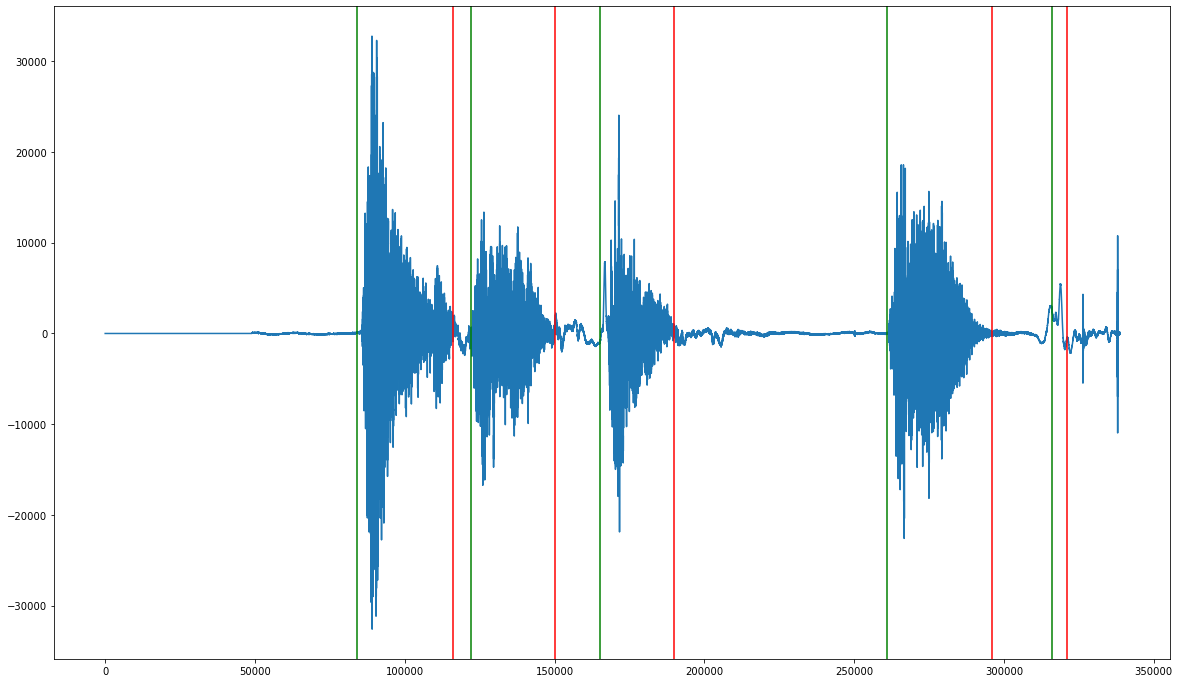

In [18]:
cut = get_cut(clf,cough)
print(cut)
plot_cut_sig(cough,cut)

## Results on different coughs

In [24]:
cough_names = []
for root, dirs, files in os.walk("Coughing/", topdown=False):
    for name in files:
        cough_names.append(os.path.join(root, name))

In [27]:
cough_names.remove('Coughing/cough_test_1.wav')

<ipython-input-22-c257c54f0ee0>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wavfile.read(cough_name)


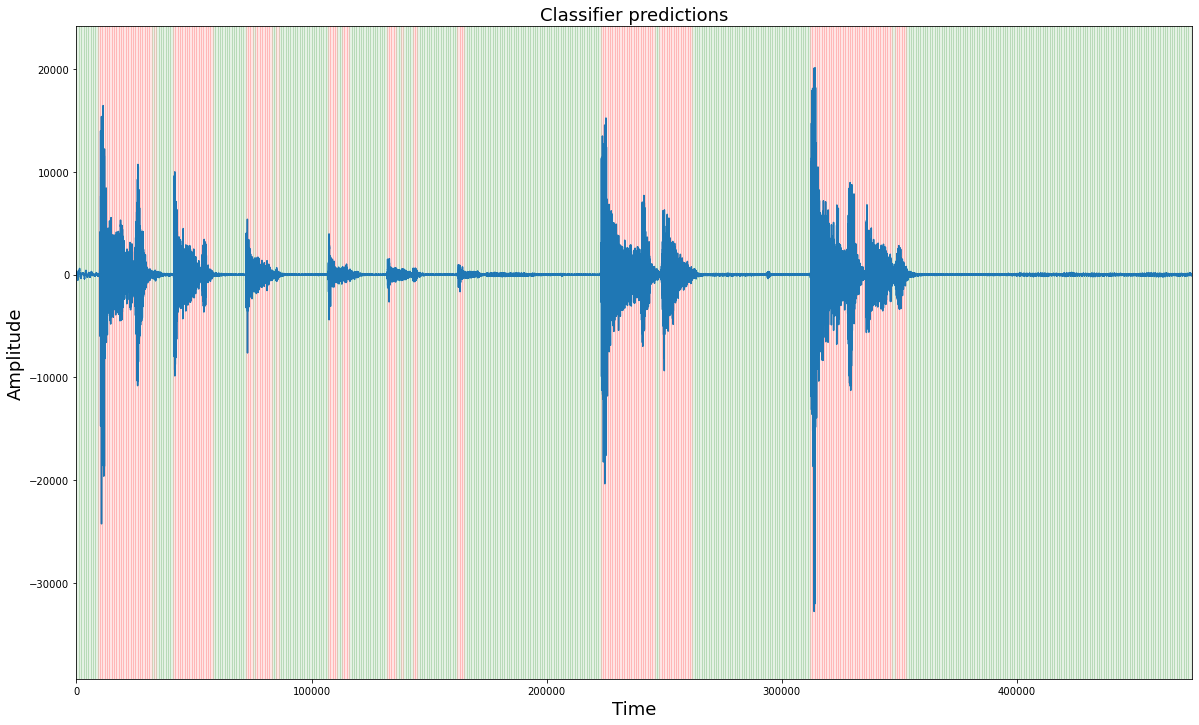

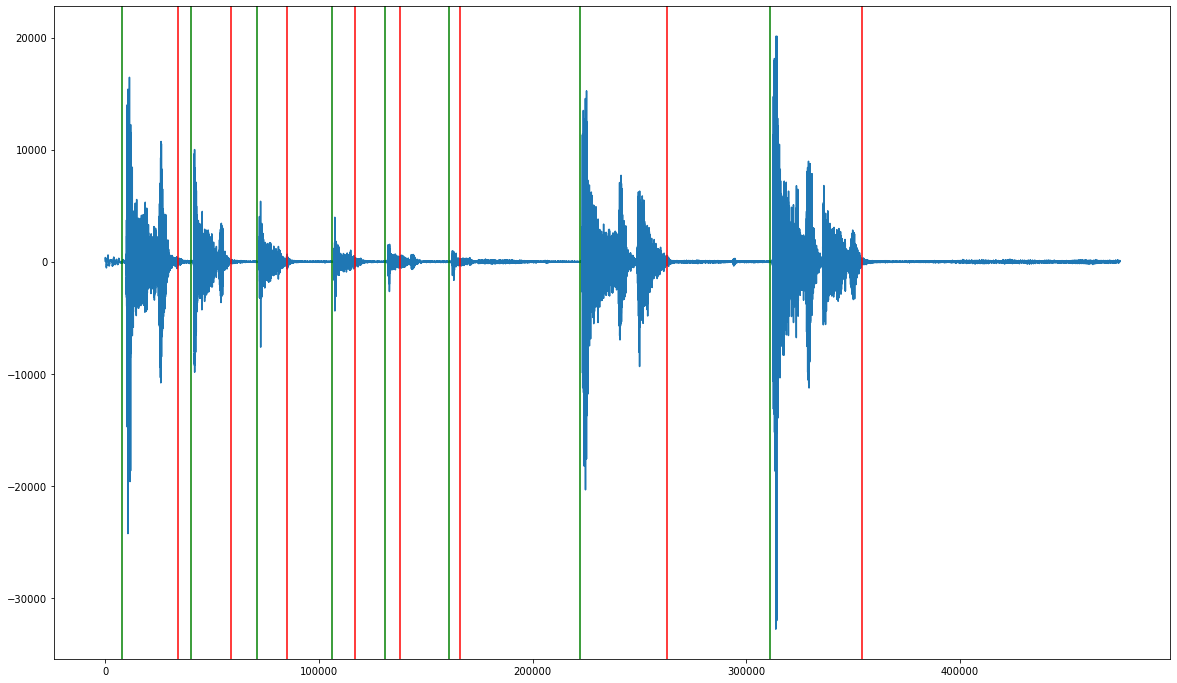

<ipython-input-22-c257c54f0ee0>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wavfile.read(cough_name)


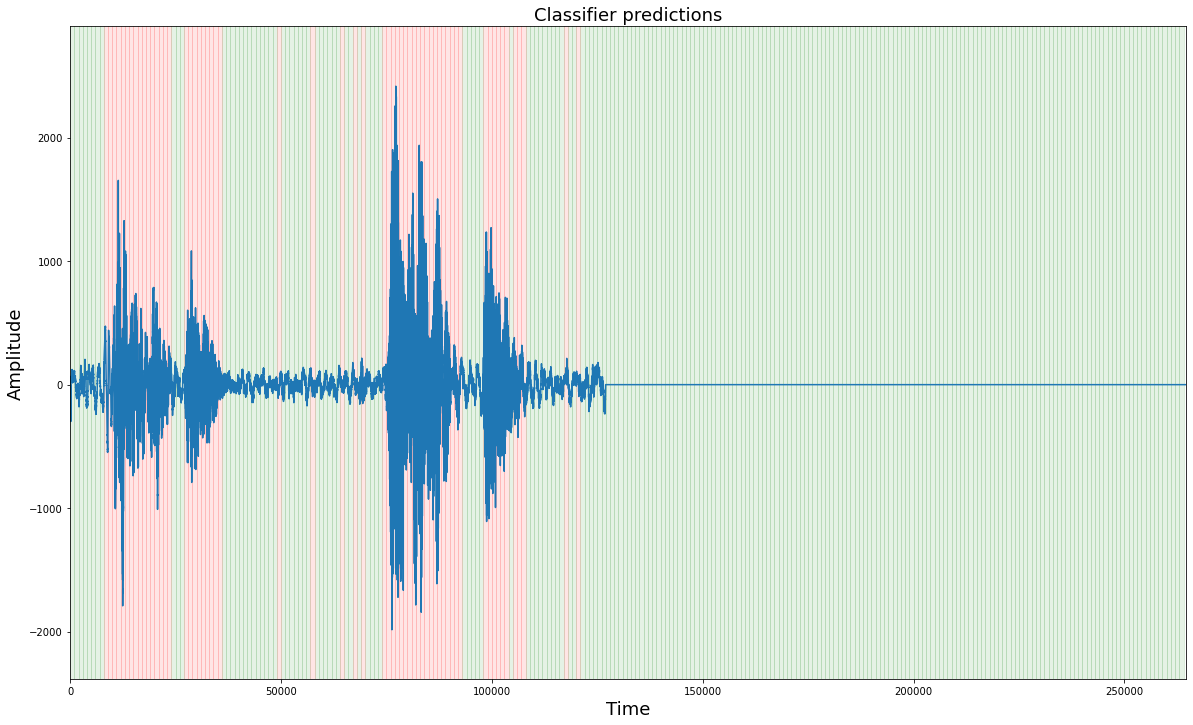

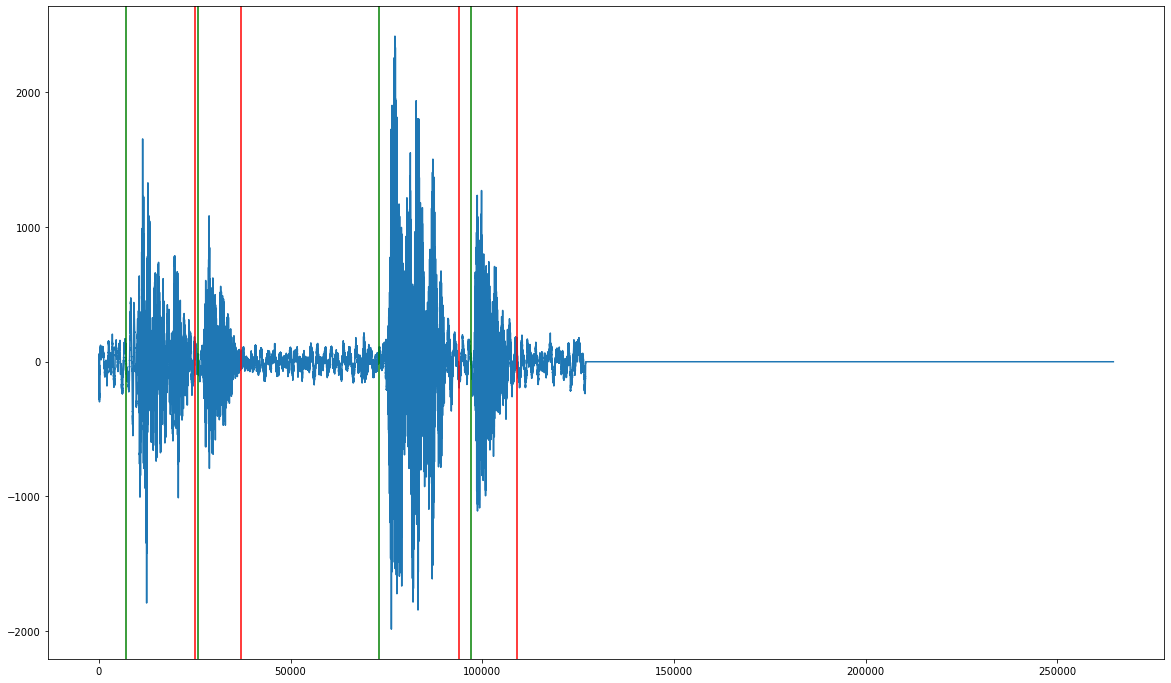

<ipython-input-22-c257c54f0ee0>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wavfile.read(cough_name)


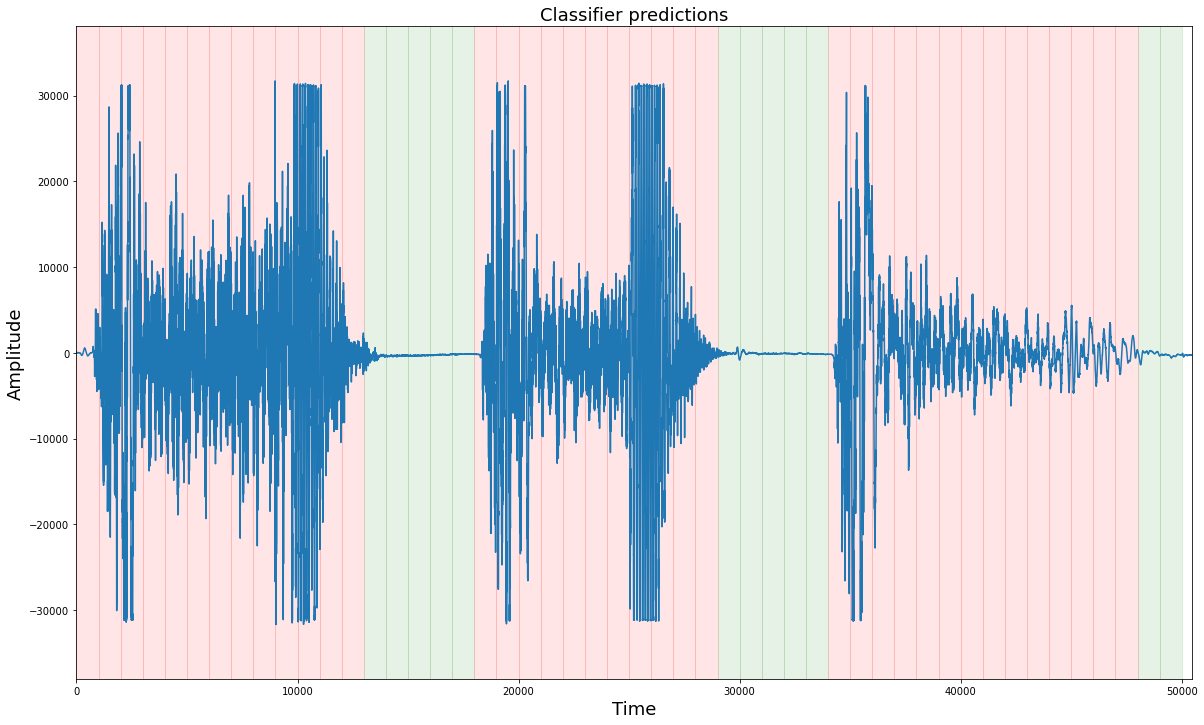

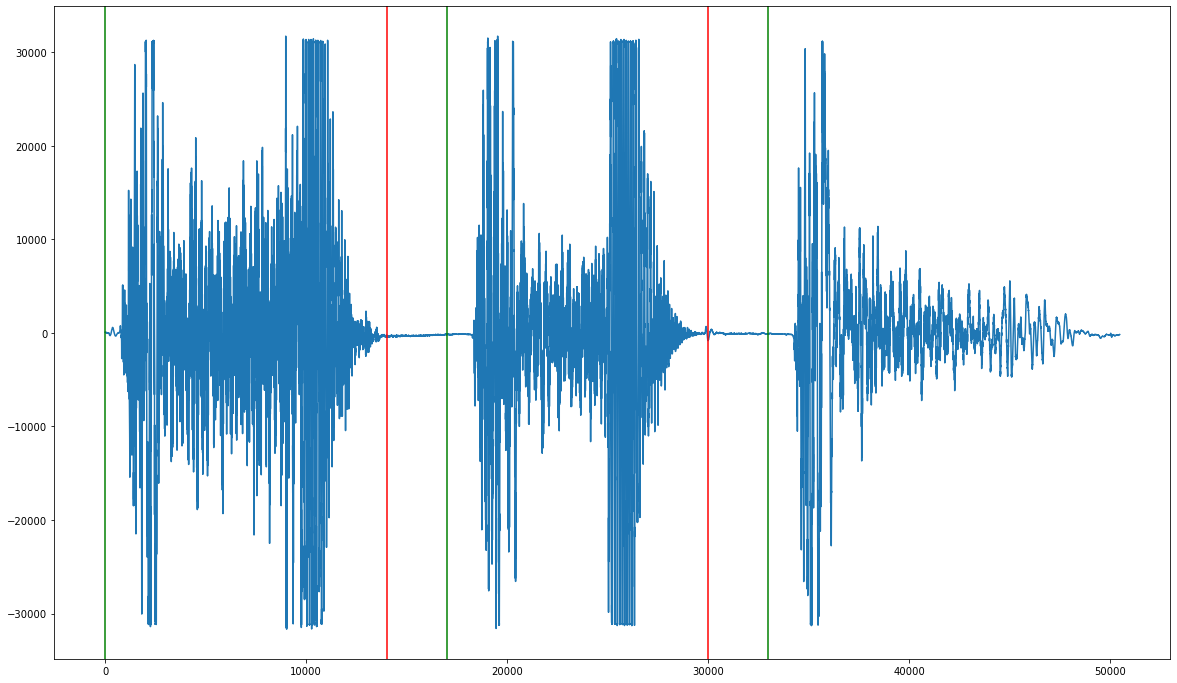

<ipython-input-22-c257c54f0ee0>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wavfile.read(cough_name)


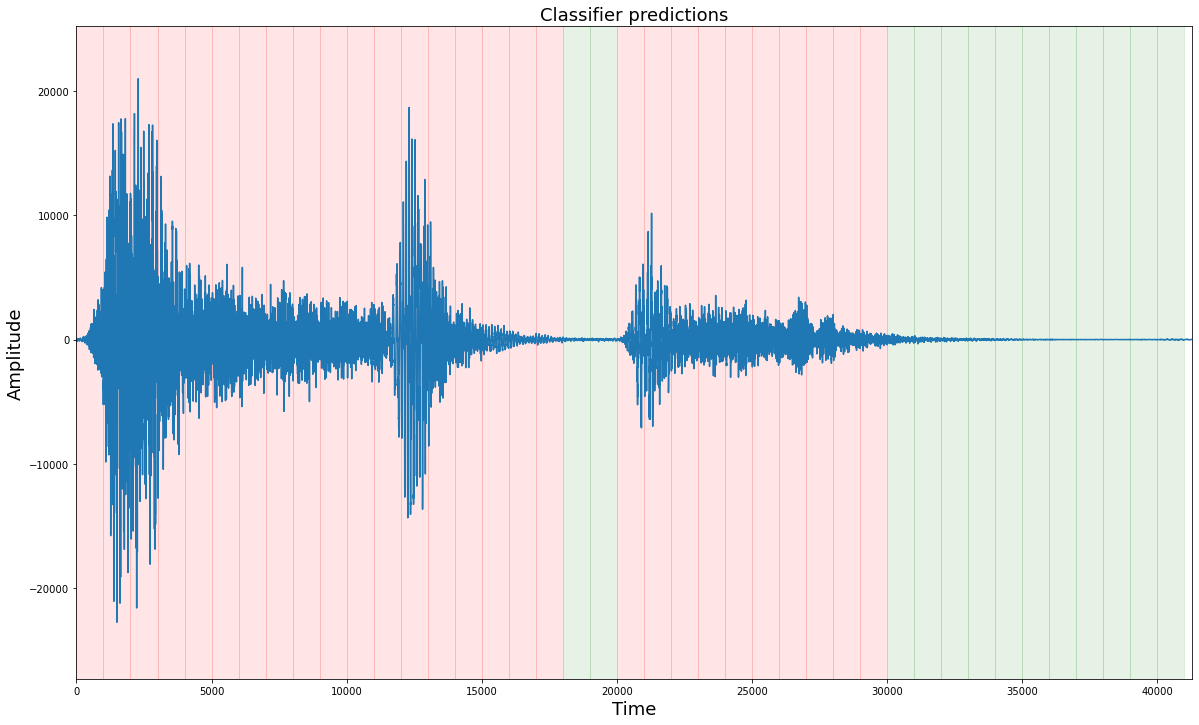

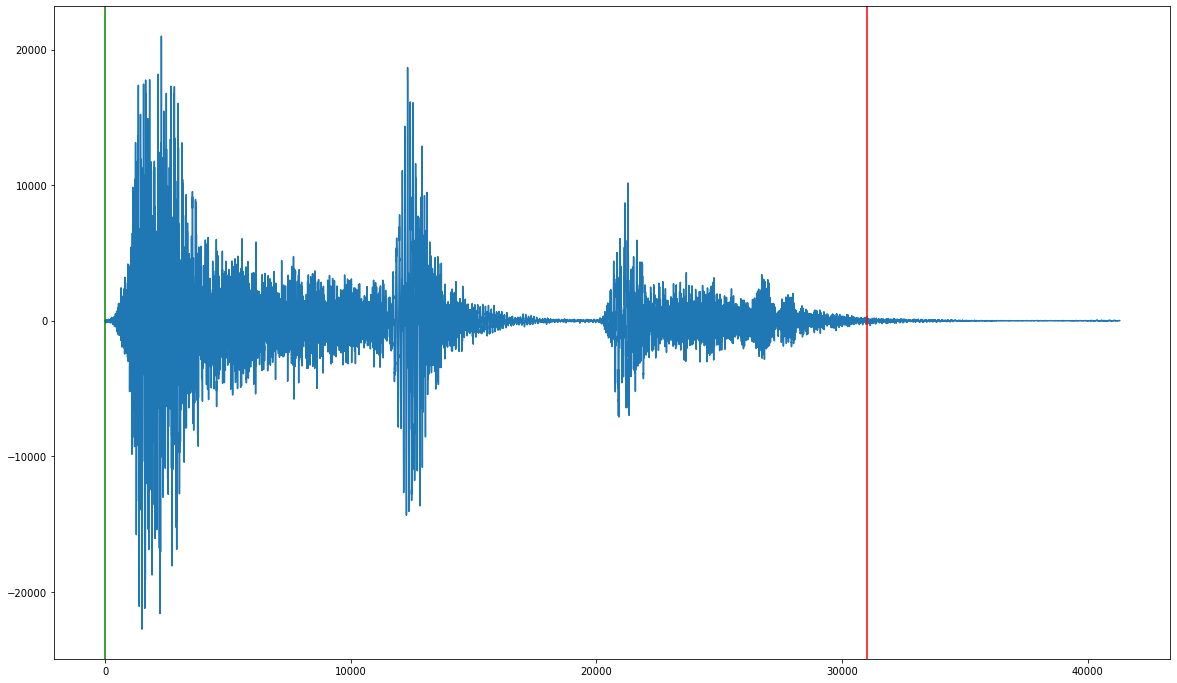

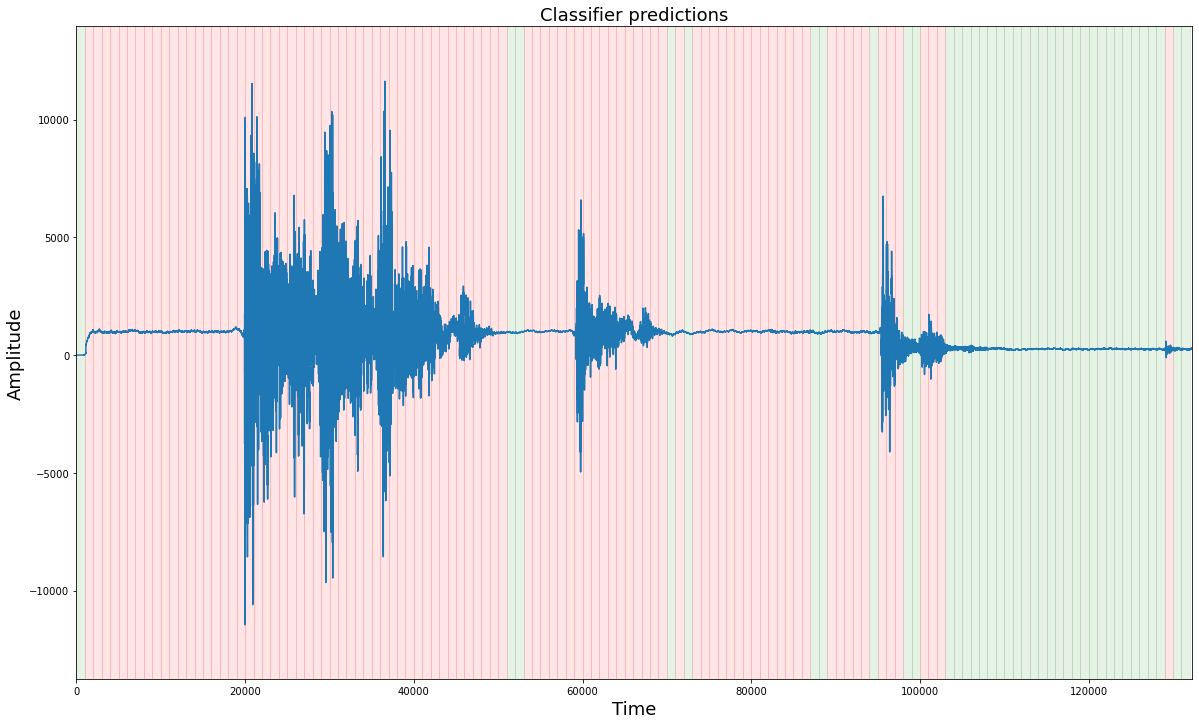

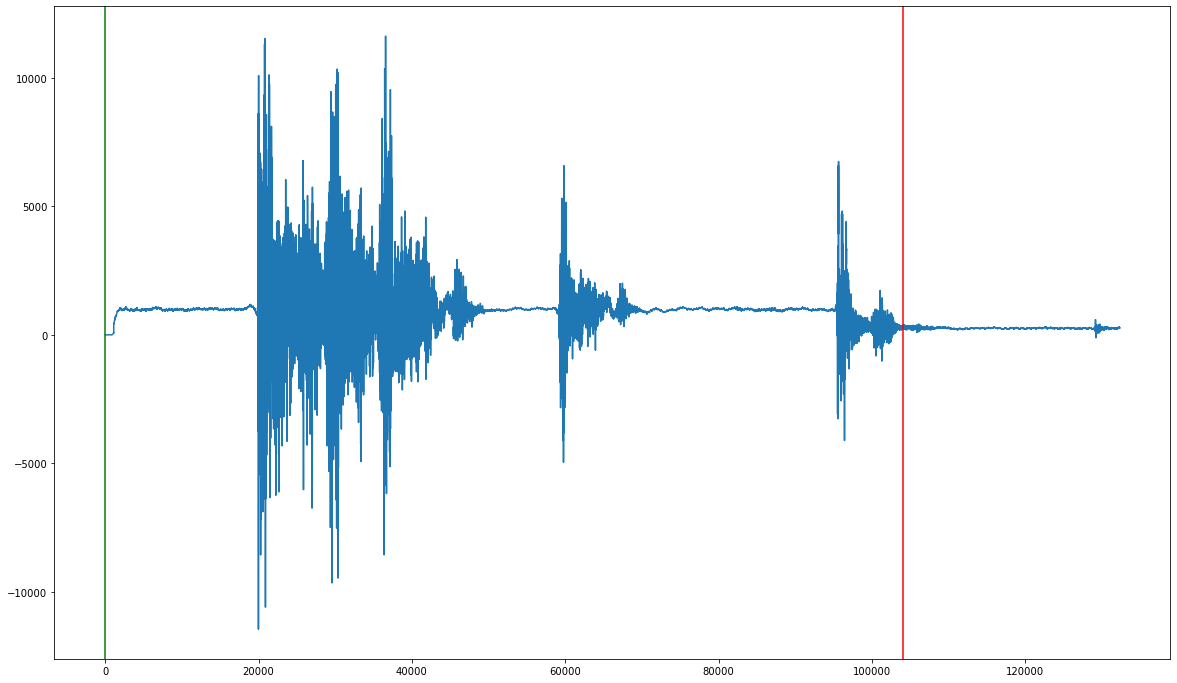

<ipython-input-22-c257c54f0ee0>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wavfile.read(cough_name)


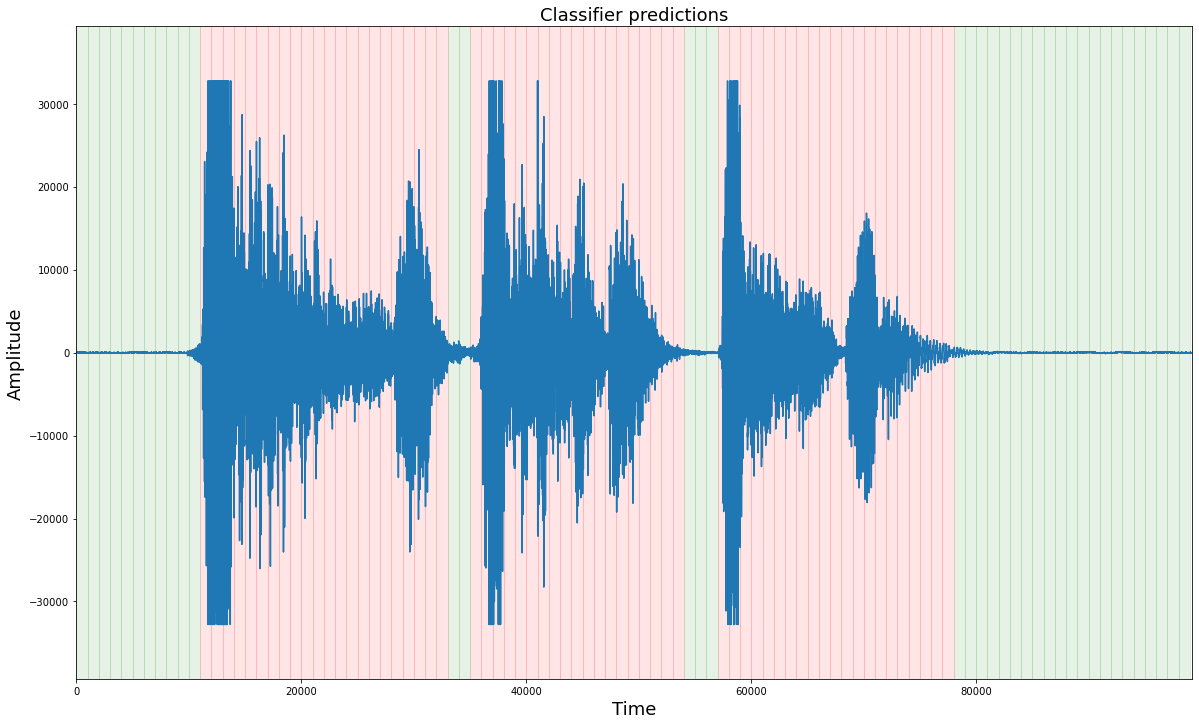

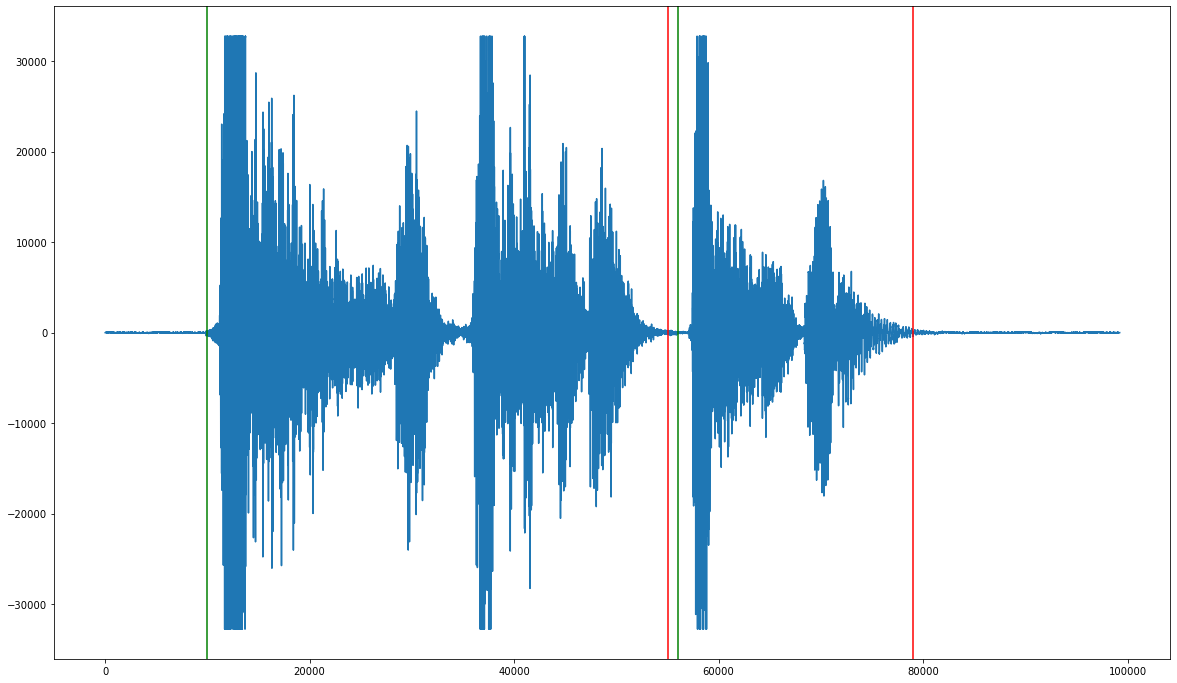

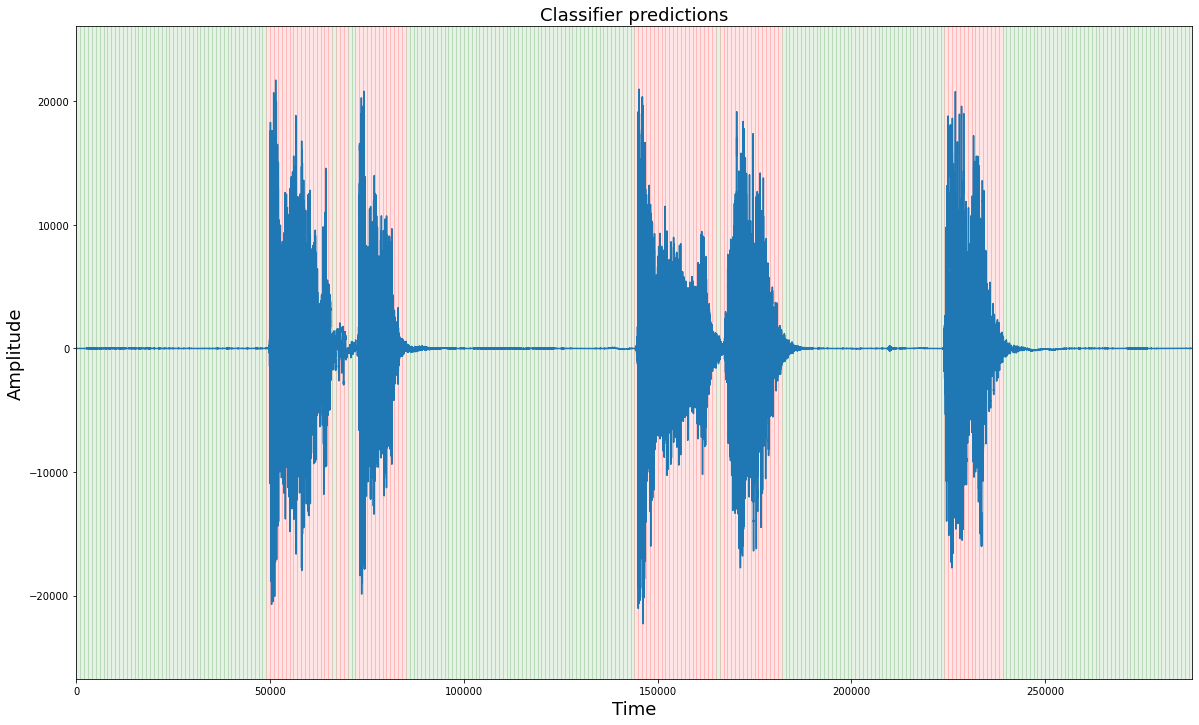

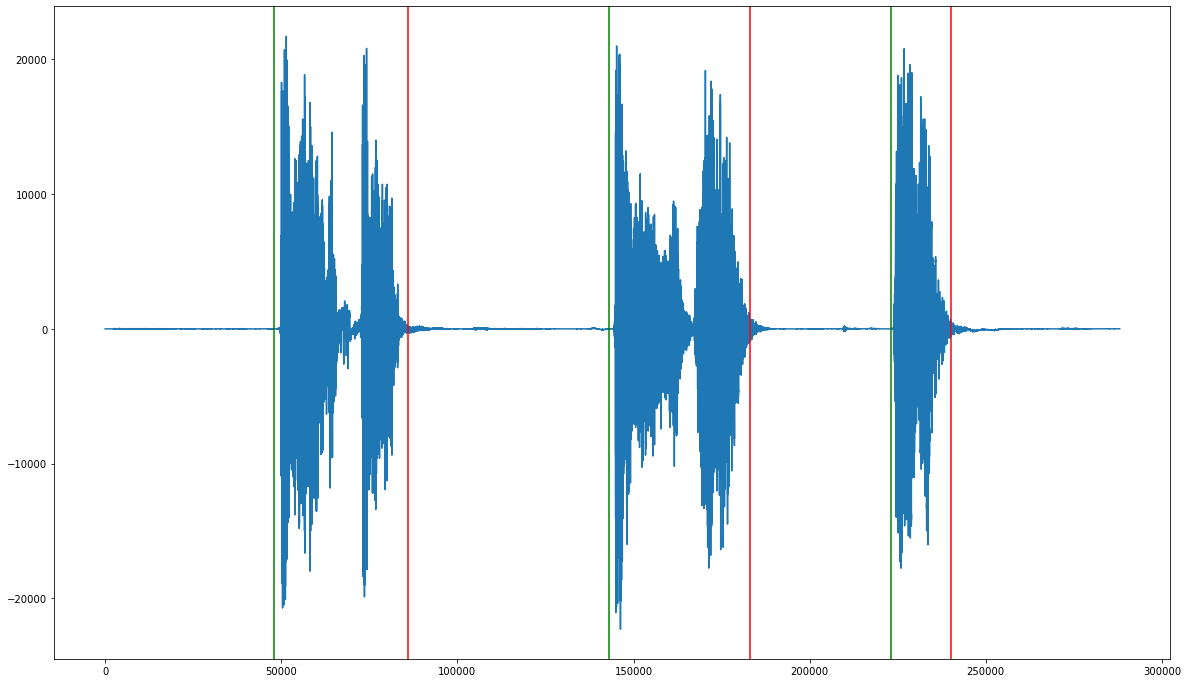

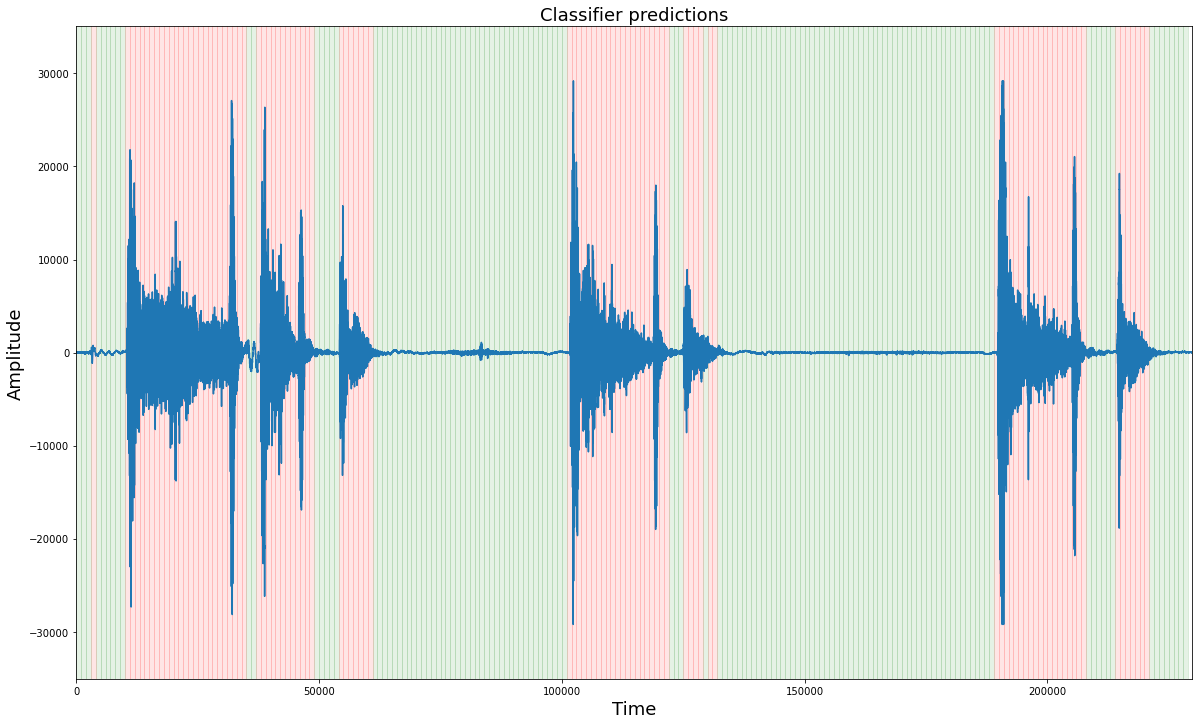

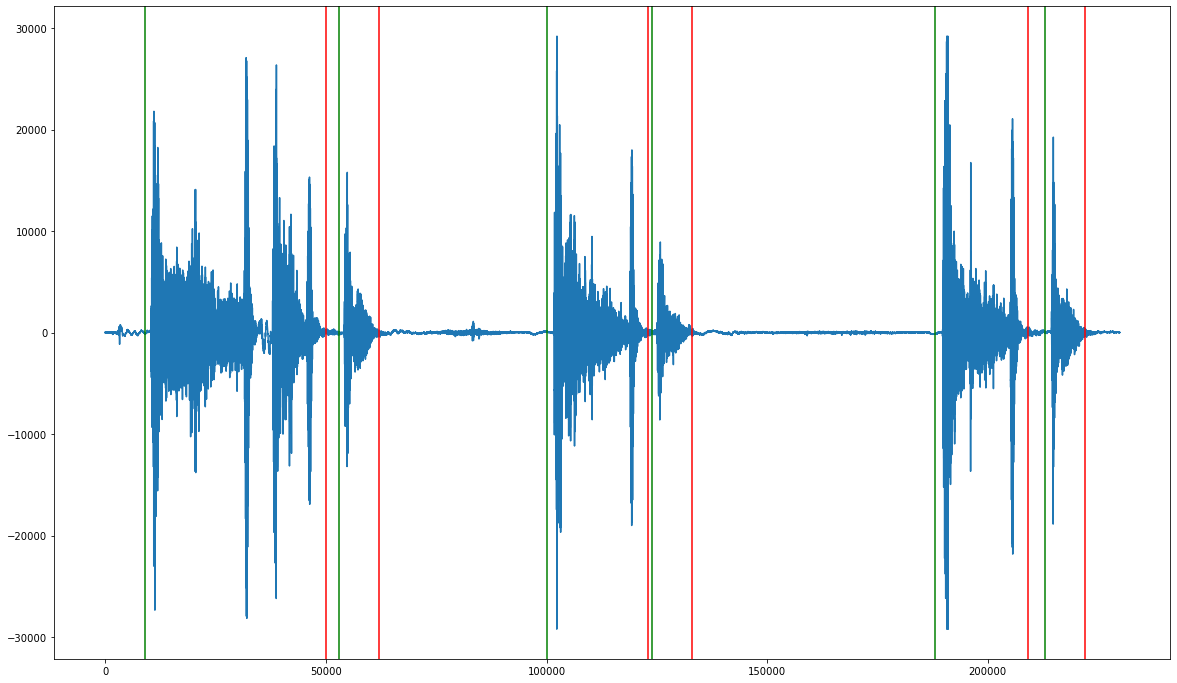

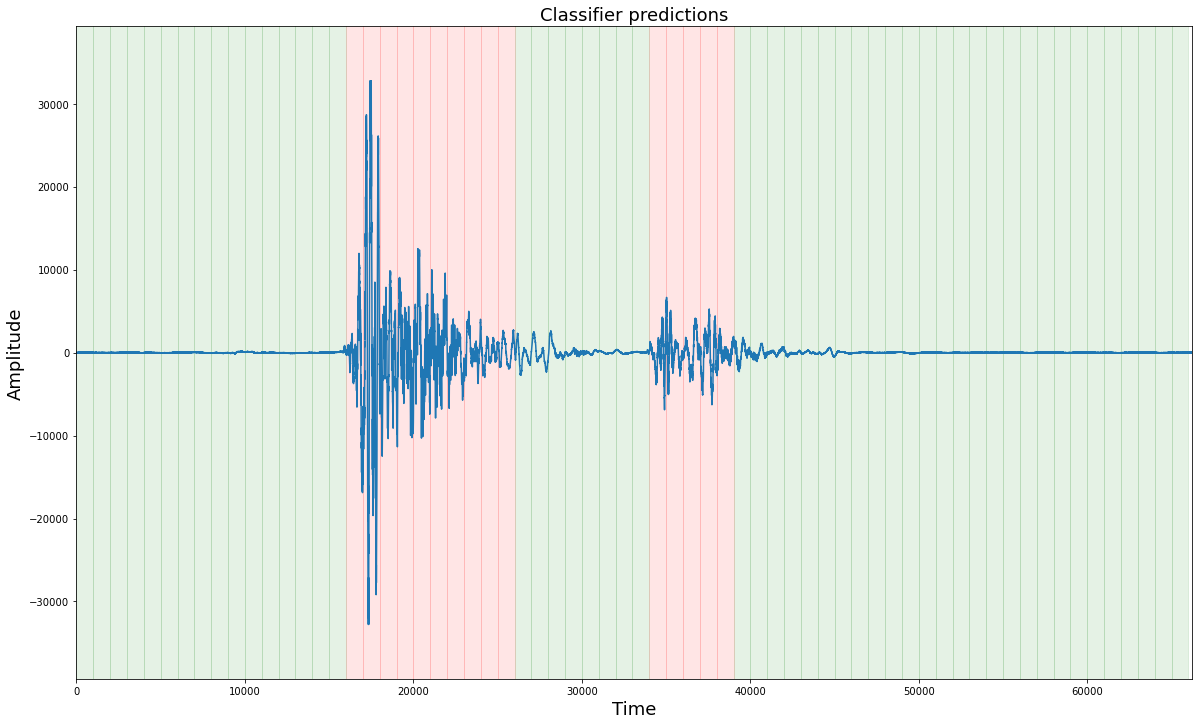

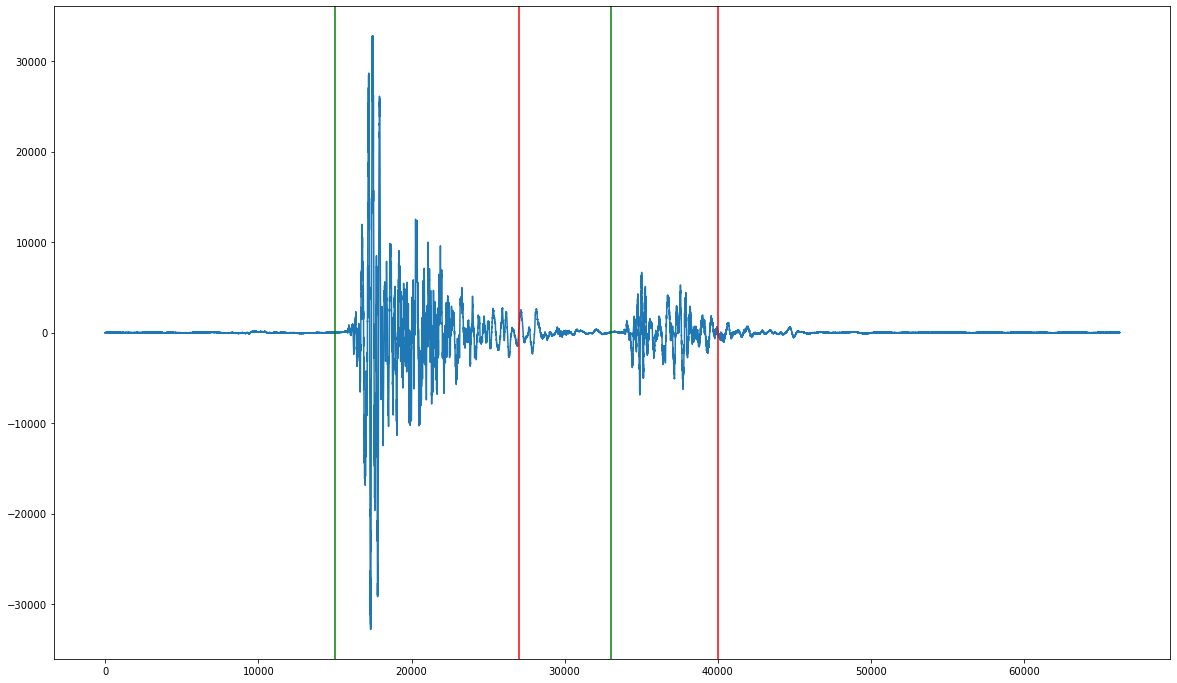

<ipython-input-22-c257c54f0ee0>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wavfile.read(cough_name)


In [22]:
for cough_name in cough_names:
    fs, sig = wavfile.read(cough_name)
    sig = sig[:,0]
    good_format.append(cough_name)
    plot_clf_pred(clf,sig)
    cut = get_cut(clf,sig)
    plot_cut_sig(sig,cut)